<a href="https://colab.research.google.com/github/Tom-Jung/ML_Colab/blob/main/28_Transfer_Learning_exam(catsanddogs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pwd

/content


In [17]:
!ls -al

total 67020
drwxr-xr-x 1 root root     4096 Apr 19 20:11 .
drwxr-xr-x 1 root root     4096 Apr 19 20:10 ..
drwxr-xr-x 3 root root     4096 Apr 19 20:11 cats_and_dogs_filtered
-rw-r--r-- 1 root root 68606236 Mar 28  2018 cats_and_dogs_filtered.zip
drwxr-xr-x 1 root root     4096 Apr  8 13:31 .config
drwxr-xr-x 1 root root     4096 Apr  8 13:32 sample_data


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-04-19 20:14:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 172.217.219.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   210MB/s    in 0.3s    

2022-04-19 20:14:16 (210 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [20]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

/content/cats_and_dogs_filtered/  is removed !!!


In [21]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/')

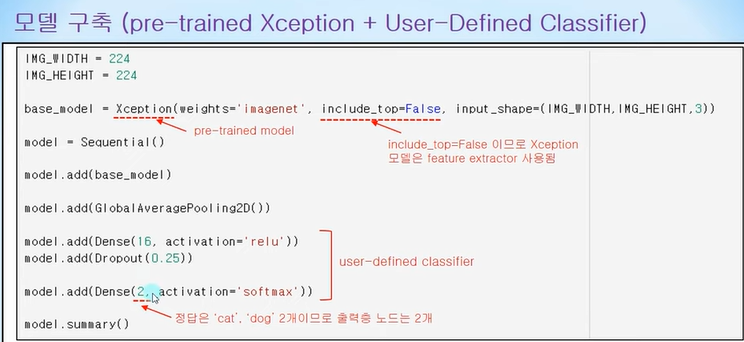

In [22]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [23]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [24]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                32784     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non-trainable params: 54,528
_____________________________________

In [25]:
# ImageDataGenerator 이용하여 데이터 불러옴

train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)

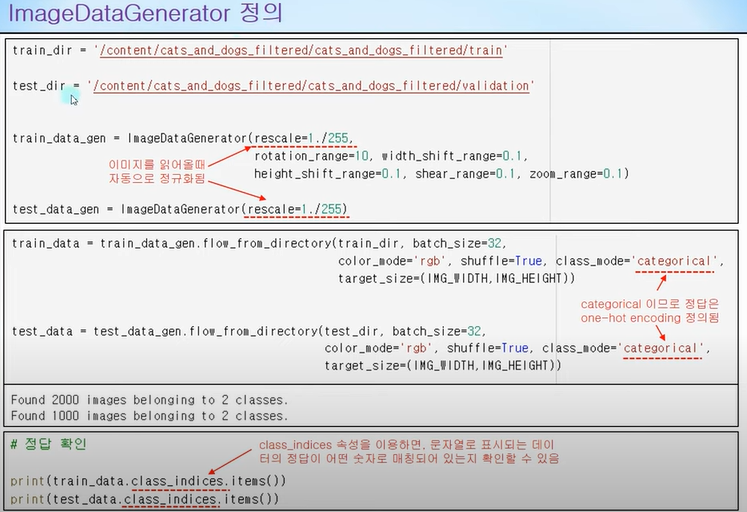

In [26]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

test_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [27]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', shuffle=True, class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32, 
                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# 정답 확인

print(train_data.class_indices.items())
print(test_data.class_indices.items())

print(len(train_data.classes))
print(len(test_data.classes))

print(train_data.num_classes)
print(test_data.num_classes)

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
2000
1000
2
2


In [29]:
# 모델 컴파일

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [30]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5,          
                             )


start_time = datetime.now()

hist = model.fit(train_data, epochs=30, 
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7395
Epoch 1: val_loss improved from inf to 0.31671, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 106s 2s/step - loss: 0.5523 - accuracy: 0.7395 - val_loss: 0.3167 - val_accuracy: 0.9390
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.9315
Epoch 2: val_loss improved from 0.31671 to 0.17732, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 97s 2s/step - loss: 0.3353 - accuracy: 0.9315 - val_loss: 0.1773 - val_accuracy: 0.9660
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9610
Epoch 3: val_loss improved from 0.17732 to 0.10304, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 96s 2s/step - loss: 0.2366 - accuracy: 0.9610 - val_loss: 0.1030 - val_accuracy: 0.9820
E

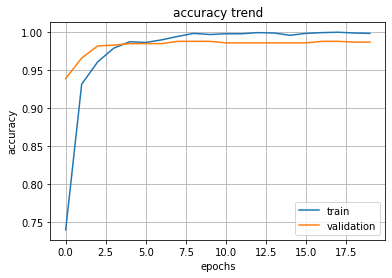

In [31]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

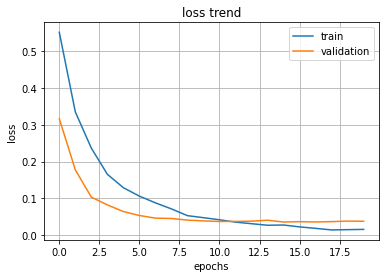

In [32]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

In [33]:
import os
import shutil

if os.path.exists('/content/test_image_dir/'):    
    
    shutil.rmtree('/content/test_image_dir/')
    print('/content/test_image_dir/  is removed !!!')

In [35]:
from google.colab import files
files.upload()

Saving test_image_dir.zip to test_image_dir.zip


{'test_image_dir.zip': b'PK\x03\x04\x14\x00\x00\x00\x08\x00\xe3`vT\xacRH\xb9"\x18\x00\x00D\x18\x00\x00\x08\x00\x00\x00cat1.jpg\x85vgP\x13\x00\xb3m\x02\x84&\xbdj\xe8\xbd\x83\xf4&B@z\x0fE\xbaJ\x0f\x01\xa4\x87.\xa1\x84\x8e$\xf4H\x8d\xf4&`\xe8`\xa5J\rE\x8a\x82\x94\x80\x80t\x15P\x14\xae\xdf\xdc\xf7\xe6\xbd\xfb\xeb\x9e\x9d\x9d\xd9\xdd3s\xf6\xfc\xd8\x1f{\xbdx\xbd\x06`0\xd23\xd4\x03\x00\x81\x00\x00\xf0_\x00\xae?\x01\x12\x01T\xe4\x14\x0cLL\xacLL\x0cl\x0c\xac\xff\x01\xfd\xff\xc9\x7f`c\xfb\x97\xac7\xb9Dyo\x82\x85\xb8XY\xf9d\xf9\x84\xc4$\xa4\xa5\xa5\xd9y\xe4U\xe4\xa5\x94E\xa5\xa4%\x80\xd4\xd4\xd4t\xb4t`\x06\x06\xb0\x14\x17\x17\x97\xd4\xff\n\x89\xff\xafV\xfe\xd7]\xbf\x010R\x02:\x81\xcc\xa4@~\x00\t#\x90\x94\x11x=\x00\xe0\xfc\xe7\x11\x04\xfc\x8f\xd5\xff\x0b \x80\x84\x0cDNJA\xf9\x8f\xd5d\x00\x00I\x81 \x10\x88\x9c\x8c\x8c\x9c\x14\xf8\xdf,)#\x19\x88\x89O\x96\x1cb\xf9(\x90\x99\x1f\x89\xae\x10\x90\x93o}K\xa0`\xd1>\x86\xba\x06\xad\xb3\xc5cpm\'\x8293\xec\xff\x04\xc0@\x00)\xf0\x7f\xc8\x03\x80$\xa4\xff\xf4\xf

In [37]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/test_image_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_image_dir/')

In [38]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('test_image_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['test_image_dir/cat2.jpg', 'test_image_dir/dog1.jpg', 'test_image_dir/dog3.jpg', 'test_image_dir/cat1.jpg', 'test_image_dir/dog2.jpg', 'test_image_dir/cat3.jpg']
6


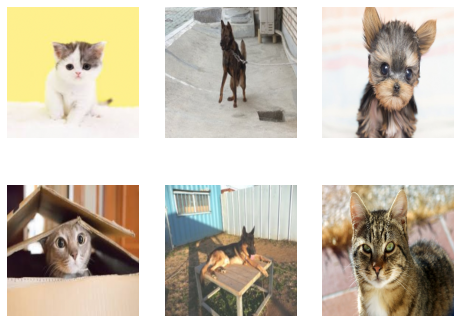

In [39]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [40]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [41]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [42]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 2)
[[0.98551625 0.01448378]
 [0.00130993 0.99869007]
 [0.3553715  0.6446285 ]
 [0.9980426  0.00195741]
 [0.00273562 0.9972644 ]
 [0.99552935 0.0044707 ]]


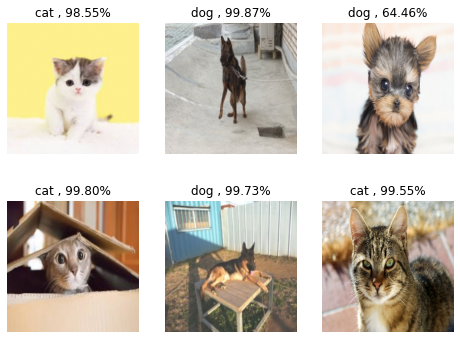

In [44]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(8,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()